Preliminary analysis using causal inference on single cell data
=

We want to show that having multiple clones can help orient causal edges in single cell data. What this amounts to (cf Petar's K99 grant application) is finding a pair (TF, target) and two clones (1, 2) such that 
1. P^1 (TF) \neq P^2(TF) 
2. P^1(target) \neq P^2(target)
3. P^1(TF|target) \neq P^2(TF|target)
4. P^1(target|TF) = P^2(target|TF)

Equivalently, we can test two conditional independence relations using off the shelf methods, where C is a domain variable indexing the clones: condition A target \independent C | TF and condition B TF \independent C | target. If A is true and B is not true, we can orient the edge as TF --> target. 

In [435]:
import pandas as pd
import numpy as np
import scanpy
from collections import Counter
from matplotlib import pyplot as plt
from scipy import special
from scipy import stats

In [424]:
ann_data = scanpy.read_h5ad('preprocessed_adata/Weinreb2020.adata.h5ad')

I got this preprocessed data from Michael Vinyard. 
This anndata object is worth exploring. You can use pandas style indexing and subsetting. The docs have a helpful schematic: https://anndata.readthedocs.io/en/latest/
The key piece is a matrix (ann_data.to_df()) where the i, j entry is the (l1) normalized count of copies of gene j transcript in cell i. The ann data object also has series as meta data for both the cells (ann_data.obs[attribute]) and the genes (ann_data.var[attribute])

In [41]:
ann_data.to_df().head()

,24,41,60,71,77,88,99,148,173,177,...,24398,24416,24499,24504,24506,24507,24520,24525,24530,24536
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.861461,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.481799,0.0,0.481799,0.0,4.336191,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.403299,0.0,0.000000,0.0,4.032991,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.632407,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [425]:
ann_data.obs['clone_idx']

0          573.0
1         1440.0
2          394.0
3            NaN
4         1972.0
           ...  
130882       NaN
130883    1374.0
130884       NaN
130885       NaN
130886       NaN
Name: clone_idx, Length: 130887, dtype: float64

In [426]:
ann_data.var['gene_id']

24       1110002J07Rik
41       1110032F04Rik
60       1500002F19Rik
71       1500026H17Rik
77       1600010M07Rik
             ...      
24507           Wfdc21
24520             Wif1
24525            Wisp1
24530             Wnk2
24536            Wnt11
Name: gene_id, Length: 2447, dtype: object

If we want to obtain, for example, the top 10 clones

In [59]:
c = Counter(ann_data.obs['clone_idx'].dropna().tolist())

top100_clones = [clone[0] for clone in c.most_common(100)]

We need to read a list of transcription factors--maybe the list they used in their analysis (Weinreb et al 2020). Unfortunately that link is broken, so we'll use a different list: https://www.nature.com/articles/ncomms15089#Abs1

In [155]:
mouse_TFs = pd.read_csv('Mus_musculus_TF.txt', sep='\t')

To simplify our life, let's just focus on these top 100 clones, which range from 48 cells to 177. At n = 48 I still roughly trust we can distinguish between unequal distributions, even though everything is very sparse. n = 20 seems like a stretch. 

In [431]:
data = ann_data[ann_data.obs['clone_idx'].isin(top100_clones)].copy()

In [432]:
data

AnnData object with n_obs × n_vars = 7381 × 2447
    obs: 'Time point', 'Population', 'Annotation', 'Well', 'cell_idx', 'clone_idx'
    var: 'gene_id', 'highly_variable'
    uns: 'highly_variable_genes_idx'
    obsm: 'X_clone', 'X_pca', 'X_spring', 'X_umap'
    layers: 'X_scaled'

For example, Trp63, in the p53 family, is mostly unexpressed across the board. We wouldn't want to move forward with this TF. 

In [434]:
for clone in top100_clones:
    single_clone = data[data.obs['clone_idx'] == clone, data.var['gene_id'] == 'Trp63']
    if single_clone.X.max() > 0:
        print(single_clone.to_df().iloc[:, 0].tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5328056812286377, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.614198625087738, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

We could query the data frame that has 100 clones and all mouse transcription factors... 

In [436]:
data = ann_data[ann_data.obs.clone_idx.isin(top100_clones), ann_data.var.gene_id.isin(mouse_TFs['Symbol'].tolist())]

But it turns out this is very sparse, and we could instead focus on the subset of genes that are non-zero in at least 1000 cells. That will help us distinguish distributions. 

In [438]:
dense_data = data[:, (data.to_df().astype(bool).sum() > 1000).tolist()]

Now we reach a strategic juncture--we need to use TFs that are well characterized! So actually, we'll just move forward with Myc. 

Myc has 1500 target genes--I think that will help our cause https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2258436/#:~:text=Among%20the%20targets%20of%20Myc,Myc%20in%20regulating%20mitochondrial%20biogenesis.
Table S1 in this paper has the human genes which are known targets of MYC. We can convert these to mouse orthologs using biomaRt, a package in R. 

In [448]:
myc = data[:, data.var['gene_id'] == 'Myc']
myc_id = myc.to_df().columns[0]

Let's check all 10^4 pairs in our data frame with 100 clones and calculate the wasserstein distance between clone1's myc expression (that's just a vector, so you could plot its distribution as a histogram) and clone2's myc expression. Do any clones stand out? 

In [450]:
tuples = []
for clone1 in set(myc.obs.clone_idx):
    print(clone1)
    for clone2 in set(myc.obs.clone_idx):
        myc1 = myc[myc.obs.clone_idx == clone1, :]
        myc2 = myc[myc.obs.clone_idx == clone2, :]
        wd = stats.wasserstein_distance(myc1.to_df()[myc_id], myc2.to_df()[myc_id])
        tuples.append([clone1, clone2, wd])

df = pd.DataFrame(tuples, columns=['clone1', 'clone2', 'wd'])

What does the distribution of Wasserstein distances look like? 

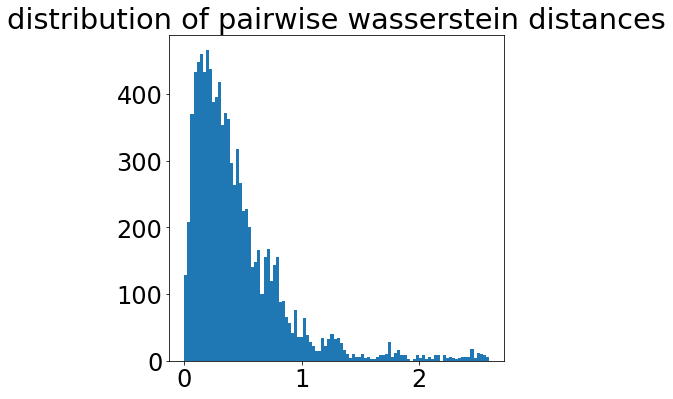

In [474]:
plt.figure(figsize=(6, 6))
plt.hist(df['wd'], bins=100);
plt.title('distribution of pairwise wasserstein distances');

So WD > 1 looks like it would pick up persistent signal that doesn't just attenuate with increasing WD. The distribution of Wasserstein distances is hard to consider analytically. It might be worth doing some simulations to get a handle on the background model here. This could be all noise, but let's try to see if there's a clone with a markedly different distribution. Such a clone would have a WD that's pretty high compared to most other clones. It would be a good clone to move forward with--a clone with a confirmed edge between C and TF, in this case Myc. 

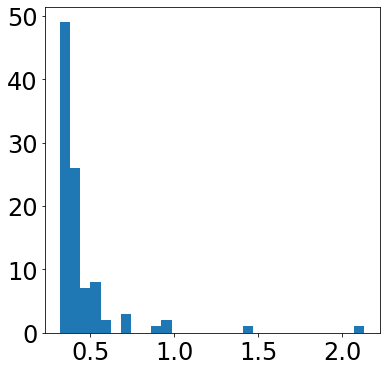

In [475]:
df = df.sort_values(by=['clone1', 'clone2'])

mean_wds = df.groupby('clone1')['wd'].mean().to_frame().reset_index()

plt.figure(figsize=(6, 6))
plt.hist(df.groupby('clone1')['wd'].mean(), bins=30);

Okay, there are some stand out clones here. We can make a heat map with clones on each axis, and the value of the i, j cell corresponds to the WD of myc distributions between clone i and clone j. 

In [476]:
df = df.merge(mean_wds.rename(columns={'wd':'mean_wd_clone1'}), on=['clone1'], how='inner')
df = df.merge(mean_wds.rename(columns={'clone1':'clone2', 'wd':'mean_wd_clone2'}), on='clone2', how='inner')

df = df.sort_values(by=['mean_wd_clone1', 'mean_wd_clone2'])

df

,clone1,clone2,wd,mean_wd_clone1,mean_wd_clone2
9595,5714.0,5714.0,0.000000,0.319128,0.319128
3495,5714.0,2256.0,0.101202,0.319128,0.325622
4795,5714.0,2887.0,0.084861,0.319128,0.326007
1395,5714.0,801.0,0.096842,0.319128,0.326859
2795,5714.0,2007.0,0.095163,0.319128,0.328264
...,...,...,...,...,...
4162,3628.0,2598.0,1.280152,2.130060,0.905218
7762,3628.0,4234.0,1.205619,2.130060,0.969499
7962,3628.0,4287.0,1.217200,2.130060,0.978936
7662,3628.0,4226.0,0.713716,2.130060,1.443801


We have to turn this into an array to feed it to matplotlib.

In [ ]:
wd_heatmap = np.array(np.array_split(df['wd'].values, 100))

wd_heatmap.shape

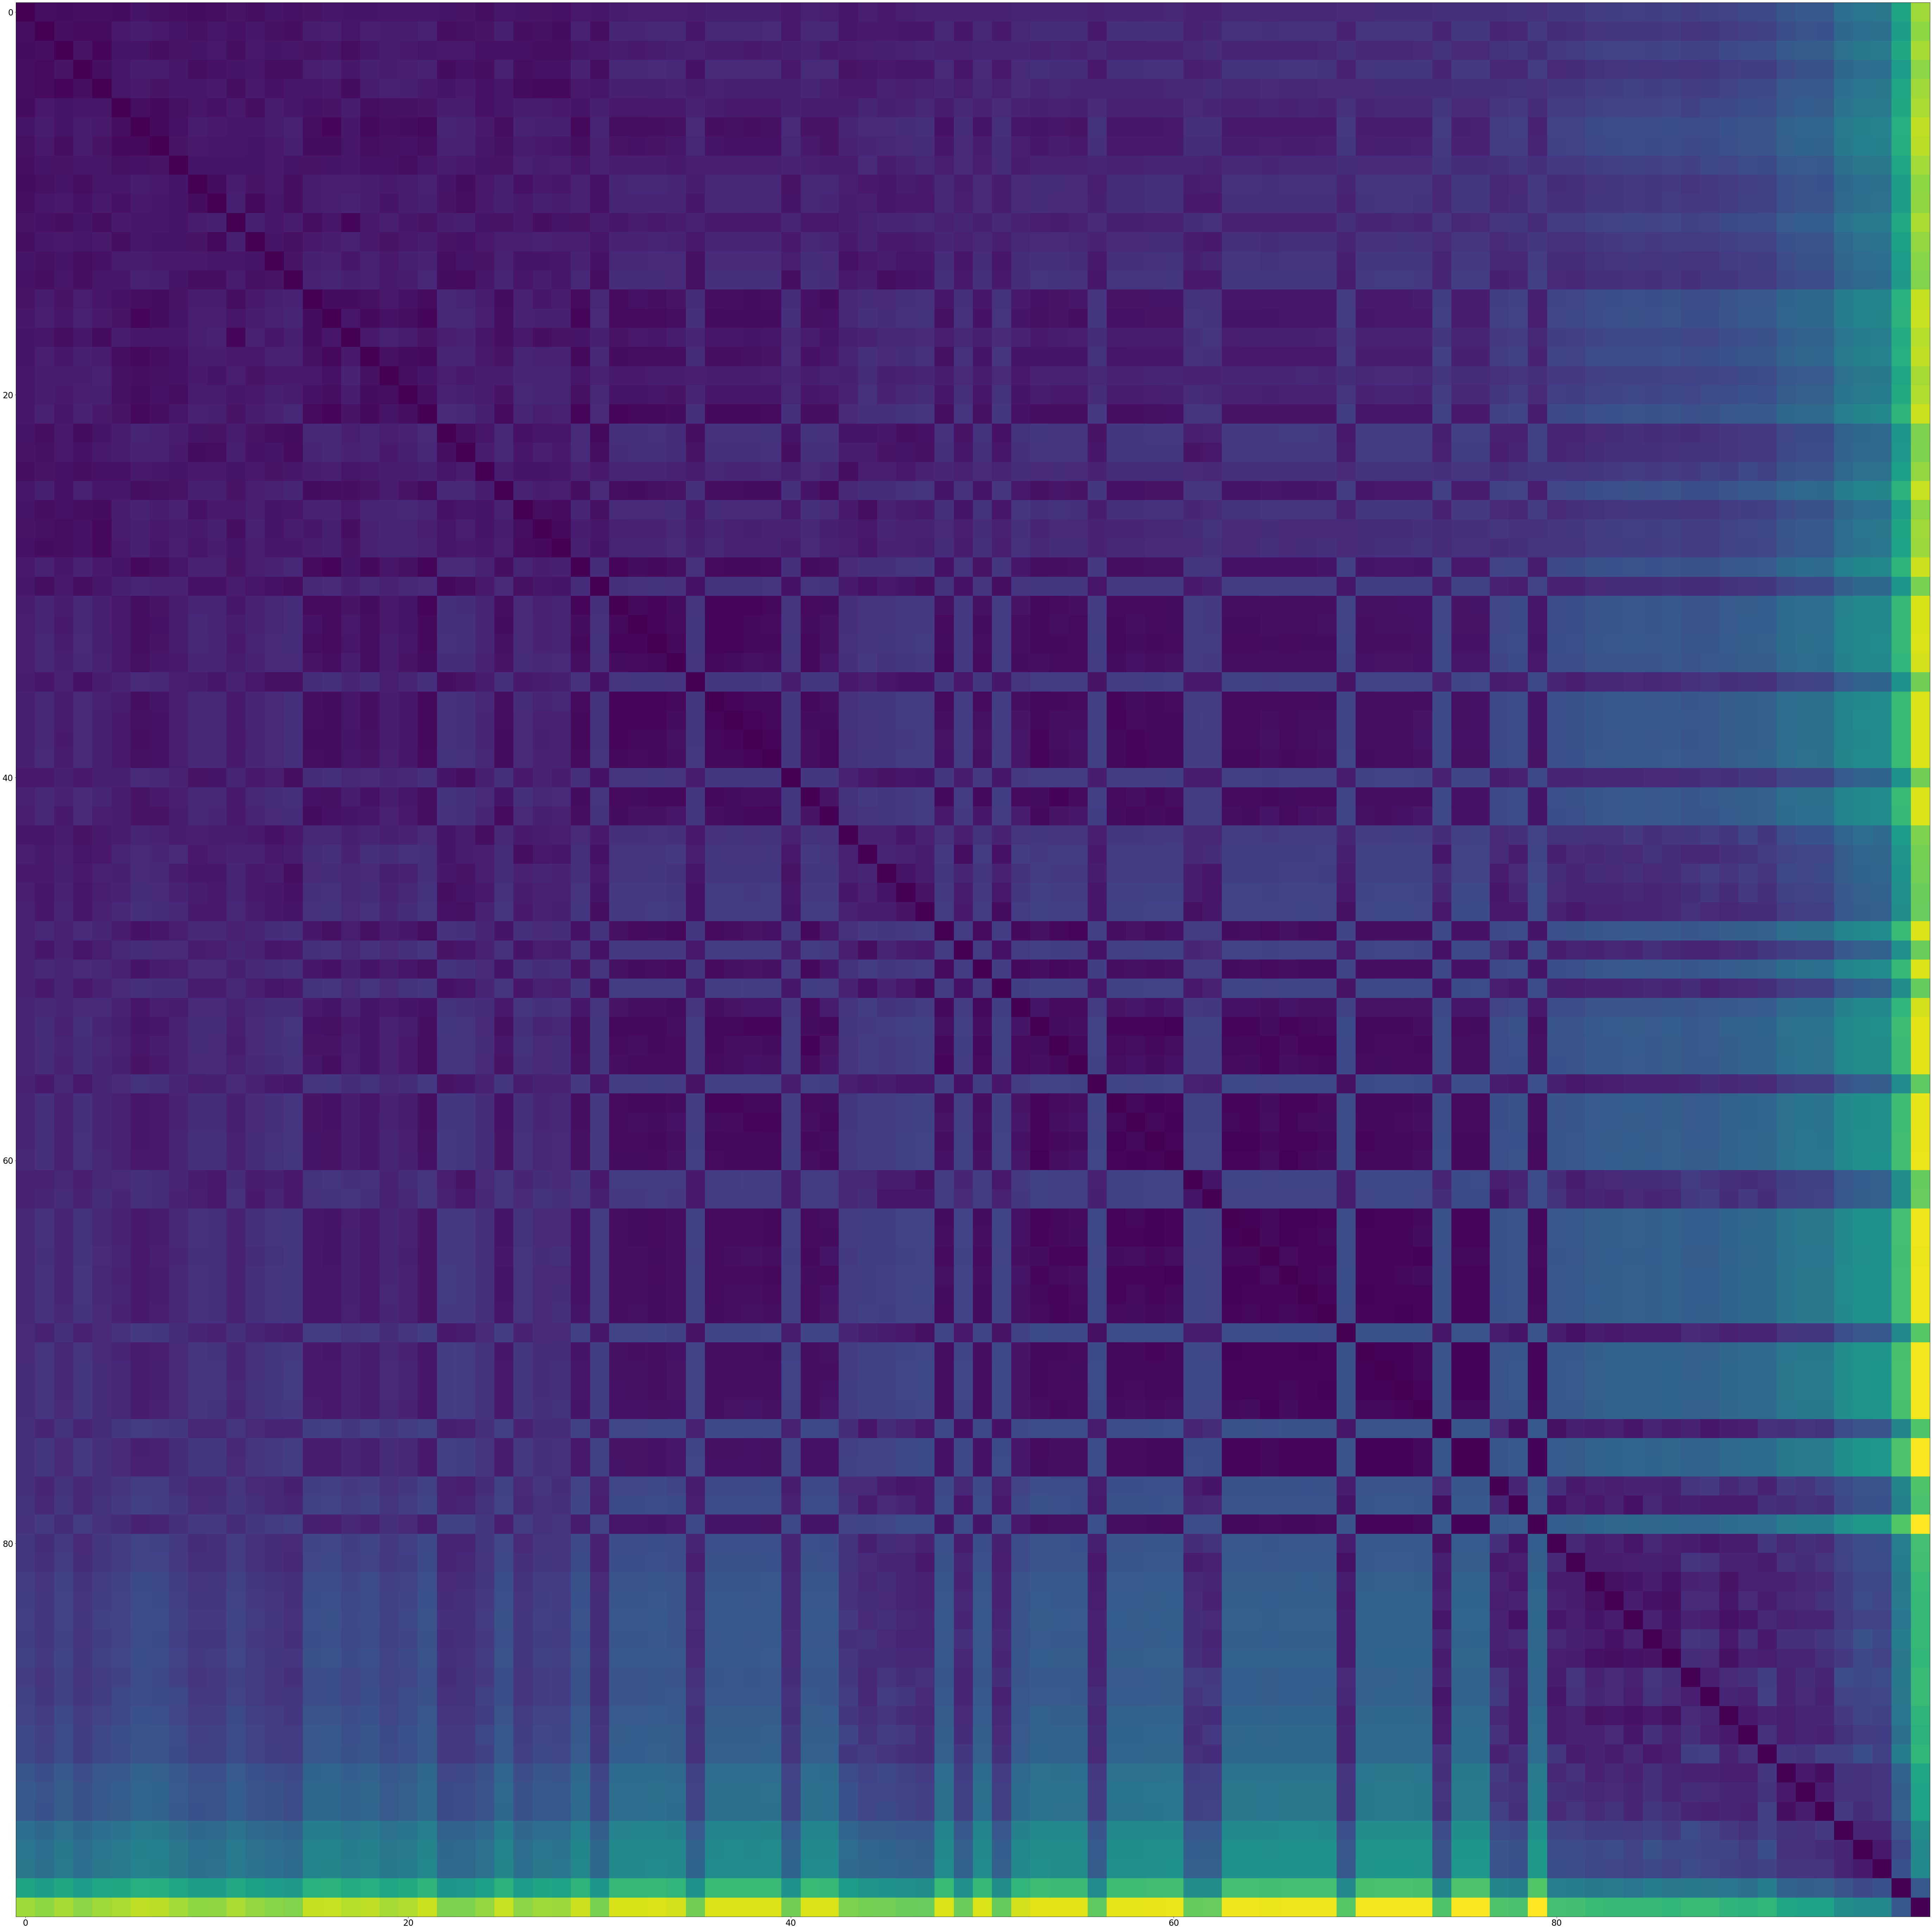

In [479]:
plt.rcParams["figure.figsize"] = (100, 100) 
plt.rcParams['font.size'] = 24
fig, ax = plt.subplots()
im = ax.imshow(wd_heatmap)

In [483]:
df[df['mean_wd_clone1'] == df['mean_wd_clone1'].max()]['clone1'].values[0]

3628.0

There's a lot to think about here, and we can't think about it much before the K99 deadline. My guess is that the boxy substructures reflect clonal structure. Closely related clones have similar myc expression distributions, so they sort next to each other when we sort on mean WD. But let's stay focused and run with 3628, a clone that has a high Wasserstein distance compared to many other clones (the stripe at the bottom row and rightmost column). We should carry all pairs featuring 3628 forward, because we may run out of pairs when we try testing conditional indepdence. 

Another thing to quickly check is the mean myc expression for each clone. I'm not sure if this is the best way to use the ann_data object (in fact I suspect there are grouping methods built into the object), but we can hackily merge the raw df with the clone idx series, then group that data frame by clone index. 

the clone with maximum mean myc expression is 3628.0


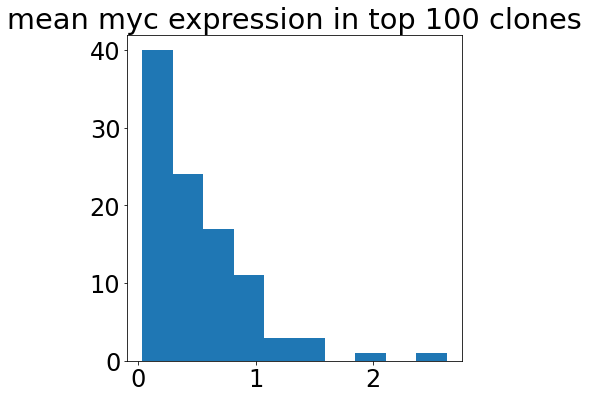

In [496]:
plt.figure(figsize=(6, 6))
plt.hist(data.to_df().merge(data.obs.clone_idx, left_index=True, right_index=True).groupby('clone_idx')[myc_id].mean());
plt.title('mean myc expression in top 100 clones')
print('the clone with maximum mean myc expression is', data.to_df().merge(data.obs.clone_idx, left_index=True, right_index=True).groupby('clone_idx')[myc_id].mean().idxmax())

Check for targets of Myc 
=

So we've identified a clone with differential expression of Myc compared to many other clones (that stripe in the heatmap), suggesting it may not just be noise. We've also identified Myc as a relatively highly expressed gene (> 1000 out of ~7000 cells have non-zero values) that's very well characterized in the literature. Now rather than manually checking Myc targets, we'll identify all genes that satisfy the conditional independence relations I listed above, using the Kernel Conditional Independence test (Zhang 2011 https://arxiv.org/abs/1202.3775). I found an implementation of this in R, so even though it's not very hard to implement (under the null hypothesis the statistic can be approximted by a gamma) I'm going to play it safe and use their method. That means writing a data frame and reading is using the R script in this directory called KCI.R. 

We'll get 2 p values for each pair of clones featuring clone 3628--one is the p value for the null hypothesis that Myc \independent C | target, the other is the p value for the null hypothesis that target \independent C | Myc. If the former is rejected and the latter accepted, we have a set of genes that are more likely (in theory) to satisfy C --> Myc --> target. We check if that set of genes is enriched for Myc targets. How to do that exactly, I'm not sure yet, but we'll cross that bridge when we come to it. 

In [497]:
all_genes_top_100_clones = ann_data[ann_data.obs.clone_idx.isin(top100_clones)]

top100_clones_dense_genes = all_genes_top_100_clones[:, (all_genes_top_100_clones.to_df().astype(bool).sum() > 1000)]

df = top100_clones_dense_genes

For example: 

In [498]:
clone1 = df[df.obs.clone_idx == 3628]

clone2 = df[df.obs.clone_idx == df.obs.clone_idx[0]]

stats.wasserstein_distance(clone1[:, clone1.var.gene_id == 'Myc'].to_df().iloc[:, 0], clone2[:, clone2.var.gene_id=='Myc'].to_df().iloc[:, 0])

1.8772298318936544

We write this so we can read it in R. Head over to KCI.R

In [501]:
df.to_df().merge(df.obs.clone_idx, left_index=True, right_index=True).to_csv('100_clones_highly_expressed_genes.tsv', sep='\t')

Now we feed those p values back into a data frame that has columns clone1, clone2, target_gene_id, wd_myc, wd_target, p_value_myc_target, p_value_target_myc. p_value_myc_target is the p value of the null hypothesis that Myc \independent C | target. 

In [395]:
def check_four_conditions(df, clone1_id=3628.0, TF = 'Myc'):
    tuples = []
    clone1 = df[df.obs.clone_idx == clone1_id]
    for clone2_id in set(df.obs.clone_idx).difference({clone1_id}):
        clone2 = df[df.obs.clone_idx == clone2_id]
        wd_myc = stats.wasserstein_distance(clone1[:, clone1.var.gene_id == 'Myc'].to_df().iloc[:, 0], clone2[:, clone2.var.gene_id=='Myc'].to_df().iloc[:, 0])        
        for gene_id in set(df.var.gene_id).difference({TF}):
            wd_target = stats.wasserstein_distance(clone1[:, clone1.var.gene_id == gene_id].to_df().iloc[:, 0], clone2[:, clone2.var.gene_id == gene_id].to_df().iloc[:, 0]) 
            wd_myc_target = 0
            wd_target_myc = 0
            tuples.append([clone1_id, clone2_id, gene_id, wd_myc, wd_target, wd_myc_target, wd_target_myc])
    return pd.DataFrame(tuples, columns=['clone1', 'clone2', 'gene_id', 'wd_myc', 'wd_target', 'wd_myc_target', 'wd_target_myc'])
    

In [396]:
potential_targets = check_four_conditions(two_clones)

In [397]:
potential_targets

,clone1,clone2,gene_id,wd_myc,wd_target,wd_myc_target,wd_target_myc
0,3628.0,394.0,Rassf4,1.87723,0.697622,0,0
1,3628.0,394.0,Bhlhe40,1.87723,0.308326,0,0
2,3628.0,394.0,Tiam1,1.87723,0.107752,0,0
3,3628.0,394.0,Camp,1.87723,0.012991,0,0
4,3628.0,394.0,Mpeg1,1.87723,1.431396,0,0
...,...,...,...,...,...,...,...
486,3628.0,394.0,Cebpb,1.87723,2.037443,0,0
487,3628.0,394.0,Cst3,1.87723,2.889844,0,0
488,3628.0,394.0,Sipa1l1,1.87723,0.424919,0,0
489,3628.0,394.0,Ero1l,1.87723,0.099883,0,0


In [404]:
df_clone

,651,731,1623,1809,2029,2112,2115,2124,2185,2247,...,23833,23885,24054,24055,24078,24372,24416,24504,24507,clone_idx
2,0.000000,0.000000,0.481799,0.963598,0.000000,15.417568,13.008573,0.481799,0.000000,0.0,...,3.854392,0.481799,0.481799,0.481799,7.226985,0.481799,0.481799,0.481799,4.336191,394.0
15,0.377392,0.000000,0.000000,0.377392,0.000000,6.793063,10.189594,0.377392,0.000000,0.0,...,0.377392,0.377392,0.000000,0.000000,1.132177,0.000000,0.754785,0.000000,2.641747,3529.0
16,0.000000,0.000000,0.000000,1.129807,0.564904,7.343748,36.718739,0.564904,0.000000,0.0,...,0.564904,0.000000,0.000000,0.000000,1.129807,0.000000,0.000000,0.000000,0.000000,5725.0
25,0.178162,0.178162,0.000000,0.178162,0.712650,6.057524,8.551798,0.890812,0.000000,0.0,...,0.000000,0.534487,0.000000,0.534487,1.068975,0.178162,0.712650,0.000000,0.534487,3438.0
30,0.000000,0.843960,0.000000,0.843960,0.000000,24.474852,10.127525,0.843960,1.687921,0.0,...,3.375842,2.531881,5.063763,1.687921,19.411089,0.843960,0.000000,2.531881,7.595644,3887.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128665,1.512743,0.000000,1.512743,0.000000,0.000000,34.793079,34.793079,1.512743,0.000000,0.0,...,1.512743,0.000000,0.000000,3.025485,18.152910,3.025485,0.000000,0.000000,10.589197,2247.0
129010,0.000000,0.000000,0.000000,0.984861,0.000000,11.818334,15.757777,1.969722,0.000000,0.0,...,1.969722,0.000000,0.000000,0.000000,4.924305,0.000000,0.984861,0.000000,4.924305,4594.0
129012,0.000000,0.000000,0.000000,0.000000,0.000000,13.491501,13.491501,0.000000,0.000000,0.0,...,1.686438,0.000000,0.000000,5.059313,11.805063,1.686438,0.000000,0.000000,0.000000,4904.0
130495,0.000000,0.000000,0.000000,3.886700,0.000000,23.320198,20.729065,3.886700,0.000000,0.0,...,3.886700,0.000000,0.000000,2.591133,3.886700,1.295567,0.000000,0.000000,33.684731,2224.0


In [405]:
df_clone.

In [384]:
two_clones = df[np.logical_or(df.obs.clone_idx==df.obs.clone_idx[0], df.obs.clone_idx == 3628)]

In [369]:
set(single_clone.obs.clone_idx).difference({})

{394.0}

In [412]:
"Myc" in df.var.gene_id.tolist()

True

In [416]:
df.var.gene_id[df.var.gene_id == 'Myc']

15353    Myc
Name: gene_id, dtype: object

In [420]:
'15353' in df_clone.columns

True

In [418]:
df.to_df().columns

Index(['651', '731', '1623', '1809', '2029', '2112', '2115', '2124', '2185',
       '2247',
       ...
       '23787', '23833', '23885', '24054', '24055', '24078', '24372', '24416',
       '24504', '24507'],
      dtype='object', length=492)